Green layer of input photo.


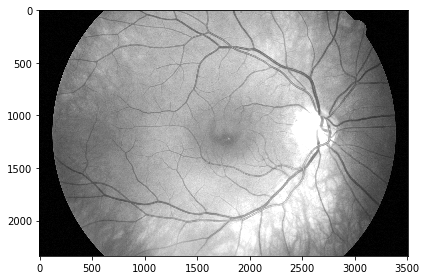

In [236]:
import os.path as path

import numpy
import rasterio as rio
import skimage
from skimage import exposure
from skimage import img_as_ubyte
from skimage import io

io.use_plugin('matplotlib', 'imshow')

test_image_name = '15_g'

def rescale(image):
    b, u = numpy.percentile(image, (2, 98))
    return skimage.exposure.rescale_intensity(image, in_range=(b, u))


def load_eye_photo(img_name):
    return img_as_ubyte(io.imread(path.join('images', f'{img_name}.jpg')))


def load_manual_expert_mask(name):
    return img_as_ubyte(io.imread(path.join('manual1', f'{name}.tif')))


def load_outline_mask(name):
    return img_as_ubyte(rio.open(path.join('mask', f'{name}_mask.tif')).read())


img = load_eye_photo(test_image_name)
img_green = img[:, :, 1]
img_green = rescale(img_green)

print("Green layer of input photo.")
io.imshow(img_green)

Mask created by classificator.


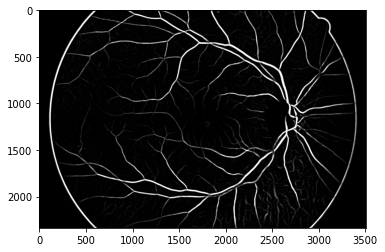

In [237]:
import matplotlib.pyplot as plt
from skimage.filters import frangi, gaussian

img_filtered_float = frangi(gaussian(img_green.copy()))
img_filtered = img_as_ubyte(rescale(img_filtered_float))

print("Mask created by classificator.")
plt.imshow(img_filtered, vmin=0, vmax=255, cmap=plt.cm.gray)

Outline mask.


/Users/tech/PycharmProjects/dno_oka/venv/lib/python3.8/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/tech/PycharmProjects/dno_oka/venv/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


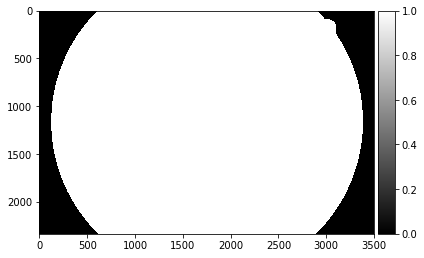

In [238]:
outline_mask = load_outline_mask(test_image_name)
outline_mask = outline_mask[0,:,:]
outline_mask = numpy.where(outline_mask == 255, 1, 0)
print("Outline mask.")
io.imshow(outline_mask, vmin=0, vmax=1, cmap=plt.cm.gray)

Mask created by classificator without outline.


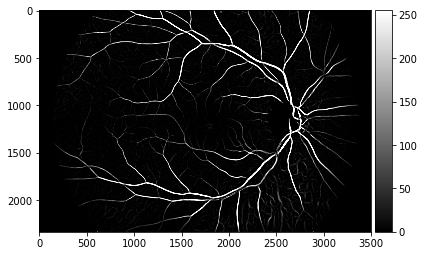

In [239]:
img_filtered_without_outline = numpy.multiply(img_filtered, outline_mask)
print("Mask created by classificator without outline.")
io.imshow(img_filtered_without_outline, vmin=0, vmax=255, cmap=plt.cm.gray)

Better quality mask created by classificator without outline.


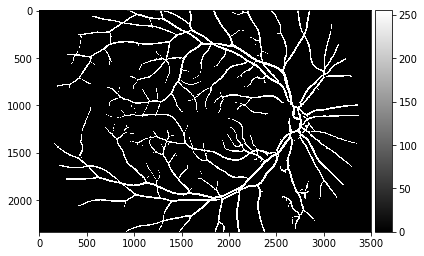

In [240]:
from skimage.filters import threshold_mean
from skimage.morphology import remove_small_objects

img = img_filtered_without_outline
thresh = threshold_mean(img)
img = numpy.where(img > thresh, True, False)

img = remove_small_objects(img, min_size=20000)
img = numpy.where(img == True, 255, 0)

print("Better quality mask created by classificator without outline.")
io.imshow(img, vmin=0, vmax=255, cmap=plt.cm.gray)

Mask created by doctor manually - ground truth.


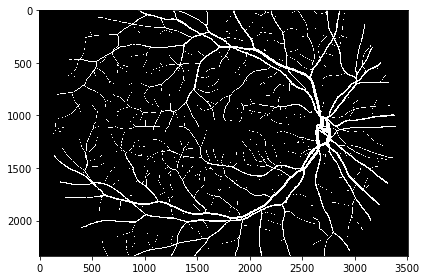

In [241]:
img_expert = load_manual_expert_mask(test_image_name)
print("Mask created by doctor manually - ground truth.")
io.imshow(img_expert, vmin=0, vmax=255, cmap=plt.cm.gray)

In [242]:
from sklearn import metrics


ground_truth = img_expert.flatten().tolist()
classifier_result = img.flatten().tolist()

confusion = metrics.confusion_matrix(ground_truth, classifier_result)

# true positives / negatives
# false positives / negatives
TN, FP = confusion[0, 0], confusion[0, 1]
FN, TP = confusion[1, 0], confusion[1, 1]

accuracy = float(TP + TN) / float(TP + TN + FP + FN)
sensitivity = float(TP) / float(TP + FN)
specificity = float(TN) / float(TN + FP)
sensitivity_specificity_mean = float(sensitivity + specificity) / 2
print(confusion)
print("accuracy", accuracy)
print("sensitivity", sensitivity)
print("specificity", specificity)
print("sensitivity_specificity_mean", sensitivity_specificity_mean)

[[7304649  281507]
 [ 116414  482774]]
accuracy 0.951386160435041
sensitivity 0.8057137325847648
specificity 0.9628920101300316
sensitivity_specificity_mean 0.8843028713573982
